# in_sample_and_cross_validation
This is an assignment for my thinkful data science course - "in_sample_and_cross_validation" Raj Prasad May 2019

[html version](https://daddyprasad5.github.io/in_sample_and_cross_validation.html) - with all the code hidden away for a quick read

[jupyter notebook version](https://github.com/daddyprasad5/thinkful/blob/master/in_sample_and_cross_validation.ipynb) - with all the code exposed in an interactive notebook

It's come time to address another potential source of error in our models: overfitting. __Overfitting__ is when your model is so excessively complex that it starts to catch random noise instead of describing the true underlying relationships. This is typically manifested with a model that evaluates as more accurate than it really is. In most situations you shouldn't be able to build a perfect model, some error is to be expected. Overfitting is extremely common and easy to do, but there are ways to guard against it. The main way is through how you evaluate your model.

Thus far we've been using our training data to evaluate our model. By this we mean that we've used the same data to train the model and to see how well the model is doing. When you think about it, some of the danger of that approach may become apparent. If we create a very elaborate model it will pick up on the nuances of the data that are just from random noise.  If we evaluate the model on the training data, that ability to pick up noise will be returned as accuracy. In reality, this isn't the case and doesn't depict how we'd really want to evaluate a model. Generally we don't care about predicting things we already know. We care about other data, new information, or other situations. This is why testing with training data really isn't what we want to do. 

But if that's the case, what can we do?

## Holdout Groups

The simplest way to combat overfitting is with a **holdout group** (or sometimes "holdback group"). All this means is that you do not include all of your data in your training set, instead reserving some of it exclusively for testing. While there is a cost to having less training data, your evaluation will be far more reliable.

When directly comparing two models that are based on different techniques or different specifications, this holdout method combats overfitting. Overfit models will see a drop in success rate outside of their training data, and so their performance will not be artificially inflated as it would be if you trained and validated your model using the whole data set. This is because they got really good at matching the patterns within the data they were trained with, but didn't actually learn the things that matter but random noise. When they try to match that random noise on new data their accuracy suffers.

How much data you choose to keep in a holdout is really up to you and depends on how much and what kind of data you have to begin with as well as what kind of model you're training. You should check and see how much variance your model has as you add more data as well as how much data it would take to maintain a reasonably representative test sample. It is, however, a balance. 30% is a common starting point, but really anything from 50% to 1% of the original dataset could be reasonable.

This seems relatively simple to code up. We'll try it below with our spam model:


In [45]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
             "master/sms_spam_collection/SMSSpamCollection"
            )
sms_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

# Enumerate our spammy keywords.
keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent']

for key in keywords:
    sms_raw[str(key)] = sms_raw.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
)

sms_raw['allcaps'] = sms_raw.message.str.isupper()
sms_raw['spam'] = (sms_raw['spam'] == 'spam')
data = sms_raw[keywords + ['allcaps']].copy()
target = sms_raw['spam']

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

In [27]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.884304932735426
Testing on Sample: 0.8916008614501076


These scores look really consistent! It doesn't seem like our model is overfitting. Part of the reason for that is that it's so simple (more on that in a bit). But we should look and see if any other issues are lurking here. So let's try a more robust evaluation technique, cross validation.

## Cross Validation

Cross validation is a more robust version of holdout groups. Instead of creating just one holdout, you create several.

The way it works is this: start by breaking up your data into several equally sized pieces, or __folds__. Let's say you make _x_ folds. You then go through the training and testing process _x_ times, each time with a different fold held out from the training data and used as the test set. The number of folds you create is up to you, but it will depend on how much data you want in your testing set. At its most extreme, you're creating the same number of folds as you have observations in your data set. This kind of cross validation has a special name: __Leave One Out__. Leave one out is useful if you're worried about single observations skewing your model, whereas large folds combat more general overfitting.



In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.89784946, 0.89426523, 0.89426523, 0.890681  , 0.89605735,
       0.89048474, 0.88150808, 0.89028777, 0.88489209, 0.89568345])

That's exactly what we'd hope to see. The array that `cross_val_score` returns is a series of accuracy scores with a different hold out group each time. If our model is overfitting at a variable amount, those scores will fluctuate. Instead, ours are relatively consistent.

Above we used the SKLearn built in functions for both of these kinds of cross validation, the documentation for which can be found [here](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels). However, the outputs from that are somewhat limited. By default it uses the `score` method. You can adjust what is returned, but you don't get all of the error types or outputs you may be interested in. That's why it's not uncommon for people to code up their own cross validation.

To make sure you understand how cross validation works, try to code it up yourself below, not relying on SKLearn:


In [58]:
# Implement your own cross validation with your spam model.
# Use train_test_split to create the necessary training and test groups

import random

#def raj_cross_val_score(bnb, data, target, cv=10)
#split the data into cv buckets

buckets = [random.randint(1,11) for i in range(len(data))]
data.loc[:,"buckets"] = pd.Series(buckets)
outcomes = pd.DataFrame(target).copy()
outcomes.loc[:,"buckets"] = pd.Series(buckets)

kfold_scores = []
for bucket in range(1,11,1): 
    X_train = data.loc[outcomes.buckets != bucket,:]
    X_test = data.loc[outcomes.buckets == bucket,:]
    y_train = outcomes.loc[outcomes.buckets != bucket,"spam"]
    y_test = outcomes.loc[outcomes.buckets == bucket,"spam"]
    kfold_scores.append(bnb.fit(X_train, y_train).score(X_test, y_test))

print(kfold_scores)

[0.875968992248062, 0.8855421686746988, 0.9019607843137255, 0.884393063583815, 0.8790983606557377, 0.8752598752598753, 0.8895463510848126, 0.8997955010224948, 0.888, 0.9096153846153846]


## What's a good score?

When we're looking at this model, we've been getting accuracy scores around .89. Intuitively that seems like a pretty good score, but in the start of this lesson we mentioned different kinds of error. We also mentioned class imbalance. Both of these things are at play here. Using the topics we introduced earlier in this lesson, try to do a more in depth evaluation of the model looking at the kind of errors we're generating and what accuracy we'd get if we just randomly guessed. You may want to use what's known as a [confusion matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to show different kinds of errors.


The dominant class rate is  0.8659368269921034
That's the accuracy rate we'd get if we always guessed 'ham'


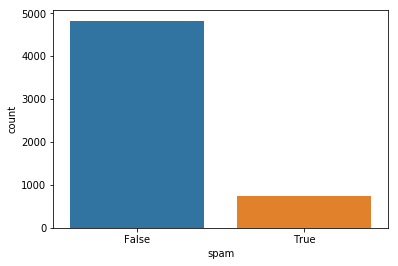

The average model score is  0.8889180481458606
The model improves on the base rate by  0.022981221153757225
Per the confusion matrix...
[[4770   55]
 [ 549  198]]
we can see most of our errors are false negatives - we are identifying a low proportion of SPAM.
To eliminate our false negatives we might need to over-sample SPAM / under-sample HAM
Or we could use a different model that allows for setting different probability thresholds - 
setting the bar lower for categorizing an email as SPAM.


In [63]:
# Perform your additional evaluation here.

#dominant class rate
sns.countplot(target)
dominant_class_rate = 1 - sum([x for x in target])/len(target)
print("The dominant class rate is ", dominant_class_rate)
print("That's the accuracy rate we'd get if we always guessed 'ham'")
plt.show()

#model improvement over dominant class rate
kfold_ave_scores = sum(kfold_scores)/len(kfold_scores)
print("The average model score is ", kfold_ave_scores)
model_improvement = kfold_ave_scores - dominant_class_rate
print("The model improves on the base rate by ", model_improvement)

#different error types - confusion matrix
print("Per the confusion matrix...")
print(sklearn.metrics.confusion_matrix(target, y_pred))
print("we can see most of our errors are false negatives - we are identifying a low proportion of SPAM.")
print("To eliminate our false negatives we might need to over-sample SPAM / under-sample HAM")
print("Or we could use a different model that allows for setting different probability thresholds - ")
print("setting the bar lower for categorizing an email as SPAM.")




## Thinking like a Data Scientist

How you choose to validate your model in real life will depend upon the kind of data you're working with and the kinds of concerns you have about the model's performance. Remember, your model is trained to fit the data you feed it, so if the situation changes your model will become less accurate. For example, if there are seasonal changes to your observed variable but you only train on one month's data, you're going to have a problem. You could test that by seeing how accurate your model is with a specific time period as your holdout, rather than a random sample. We'll cover techniques for dealing with time more later.

## Overfitting and Naive Bayes

Overfitting is always possible, but some models are more susceptible to it than others. Naive Bayes is actually pretty good for avoiding overfitting. This is largely because the assumptions are so simple, particularly the assumed independence between any two independent variables. One of the sources of overfitting is when a model tries to map complex interactions between variables that aren't really there or significant. Naive Bayes cannot do this because it assumes they are all independent and therefore not interacting. It's a nice characteristic at times, but it does mean it doesn't take into account how your features affect each other.

Also, one final note on our models here. They weren't overfitting, but they weren't telling us much either. They were just barely more accurate than the dominant class. Discuss with your mentor why that is and what you could do to improve the model.
